In [10]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt

### Define paths for the model and data of interest

In [40]:
# Define the paths to the peak BEDs and profile BigWigs
base_path = "/users/amtseng/tfmodisco/data/interim/ENCODE/"

peaks_bed = os.path.join(base_path, "SPI1/SPI1_ENCSR000BGW_K562_peakints.bed.gz")

prof_bigwigs = [
    (os.path.join(base_path, e_1), os.path.join(base_path, e_2))
    for e_1, e_2 in [
        ("SPI1/SPI1_ENCSR000BGQ_GM12878_neg.bw",
        "SPI1/SPI1_ENCSR000BGQ_GM12878_pos.bw"),
        ("SPI1/SPI1_ENCSR000BGW_K562_neg.bw",
        "SPI1/SPI1_ENCSR000BGW_K562_pos.bw"),
        ("SPI1/SPI1_ENCSR000BIJ_GM12891_neg.bw",
        "SPI1/SPI1_ENCSR000BIJ_GM12891_pos.bw"),
        ("SPI1/SPI1_ENCSR000BUW_HL-60_neg.bw",
        "SPI1/SPI1_ENCSR000BUW_HL-60_pos.bw"),
        ("SPI1/control_ENCSR000BGG_K562_neg.bw",
        "SPI1/control_ENCSR000BGG_K562_pos.bw"),
        ("SPI1/control_ENCSR000BGH_GM12878_neg.bw",
        "SPI1/control_ENCSR000BGH_GM12878_pos.bw"),
        ("SPI1/control_ENCSR000BIH_GM12891_neg.bw",
        "SPI1/control_ENCSR000BIH_GM12891_pos.bw"),
        ("SPI1/control_ENCSR000BVU_HL-60_neg.bw",
        "SPI1/control_ENCSR000BVU_HL-60_pos.bw")
    ]
]
num_tasks = int(len(prof_bigwigs) / 2)
# Path to saved model
# model_path = "/users/amtseng/tfmodisco/models/trained_models/SPI1_TEST_softmax/1/model_ckpt_epoch_7.h5"
model_path = "/users/amtseng/tfmodisco/models/trained_models/SPI1_sigmoid/1/model_ckpt_epoch_3.h5"

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [5]:
# Define some constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4
profile_norm_type = "sigmoid"

In [6]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles, in order of BigWigs given in `prof_bigwigs`
coords_to_vals_list = [
    (
        make_profile_dataset.CoordsToVals(path_1, profile_length),
        make_profile_dataset.CoordsToVals(path_2, profile_length)
    )
    for path_1, path_2 in prof_bigwigs
]
def coords_to_profs(coords):
    return np.stack([
        np.stack([ctv_1(coords), ctv_2(coords)], axis=1)
        for ctv_1, ctv_2 in coords_to_vals_list
    ], axis=1)

In [7]:
# Maps single coordinate to input sequence and profiles for the network
def coord_to_network_inputs(chrom, start, end):
    input_seq = coords_to_seq([(chrom, start, end)])
    profs = coords_to_profs([(chrom, start, end)])
    return input_seq, profs

In [8]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

In [9]:
# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

### Predicting and plotting profiles

In [41]:
# Import the model
custom_objects = {
    "tf": tf,
    "profile_loss": train_profile_model.get_profile_loss_function(num_tasks, profile_length, profile_norm_type),
    "count_loss": train_profile_model.get_count_loss_function(num_tasks)
}
model = keras.models.load_model(model_path, custom_objects=custom_objects)

In [68]:
[
    np.any(np.isnan(layer.get_weights()[0])) for layer in model.layers if layer.get_weights()
]

[True, True, True, True, True, True, True, True, False, True, False]

In [64]:
def predict_coord(chrom, start, end, profile_norm_type):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions AND the true values from the dataset.
    The returned profiles are in terms of raw counts, and the returned counts are
    also raw. Returned values are all NumPy arrays.
    """
    input_seq, profiles = coord_to_network_inputs(chrom, start, end)
    
    print(input_seq)
    
    # Make length come before strands in profiles
    profiles = np.transpose(profiles, [0, 1, 3, 2])

    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]

    # Run through the model
    logit_pred_profs, log_pred_counts = model.predict([input_seq, cont_profs])
    
    print(logit_pred_profs)
    # Convert logit profile predictions to probabilities
    if profile_norm_type == "softmax":
        pred_prof_probs = scipy.special.softmax(logit_pred_profs, axis=2)
    else:
        sig_pred_profs = scipy.special.expit(logit_pred_profs)
        print(sig_pred_profs.shape)
        pred_prof_probs = sig_pred_profs / np.expand_dims(np.sum(sig_pred_profs, axis=2), axis=2)
        print(pred_prof_probs.shape)
    
    # Convert log counts to counts
    pred_counts = np.exp(log_pred_counts) - 1
    
    # Convert profile probabilities to profile counts
    pred_profs = pred_prof_probs * np.expand_dims(pred_counts, 2)
    
    # Add true profiles to get true counts
    true_counts = np.sum(true_profs, axis=2)
    
    return pred_profs[0], pred_counts[0], true_profs[0], true_counts[0]

In [16]:
def plot_profiles(pred_profs, true_profs, normalize=True, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[1]
    if normalize:
        pred_profs = pred_profs / np.expand_dims(np.sum(pred_profs, axis=1), axis=1)
        true_profs = true_profs / np.expand_dims(np.sum(true_profs, axis=1), axis=1)
    fig, ax = plt.subplots(num_tasks, figsize=(15, 20))
    for i in range(num_tasks):
        ax[i].plot(pred_profs[i,:,0], color="royalblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="darkorange", alpha=0.5)
    if title:
        fig.suptitle(title)

### View predictions

In [17]:
# Sample some positive coordinates
pos_coords_table.sample(10)

,0,1,2
191,chr1,10384916,10385916
7511,chr12,40564696,40565696
32541,chrX,153725915,153726915
5325,chr10,119785721,119786721
1,chr1,906402,907402
2925,chr1,181504533,181505533
27166,chr6,154707039,154708039
30652,chr9,665986,666986
13885,chr18,830115,831115
10642,chr15,73633094,73634094


In [18]:
# Sample some negative coordinates
neg_coord_sampler.sample_intervals(10)

array([['chr14', 57189364, 57190710],
       ['chr8', 4953918, 4955264],
       ['chr10', 98450895, 98452241],
       ['chr1', 13999293, 14000639],
       ['chrX', 59871620, 59872966],
       ['chr9', 130388938, 130390284],
       ['chr3', 190845948, 190847294],
       ['chr1', 15768849, 15770195],
       ['chr18', 10480998, 10482344],
       ['chr2', 26738811, 26740157]], dtype=object)

[[[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]]
[[[[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]

  [[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]

  [[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]

  [[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]]]
(1, 4, 1000, 2)
(1, 4, 1000, 2)
[[[nan nan]
  [nan nan]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]]


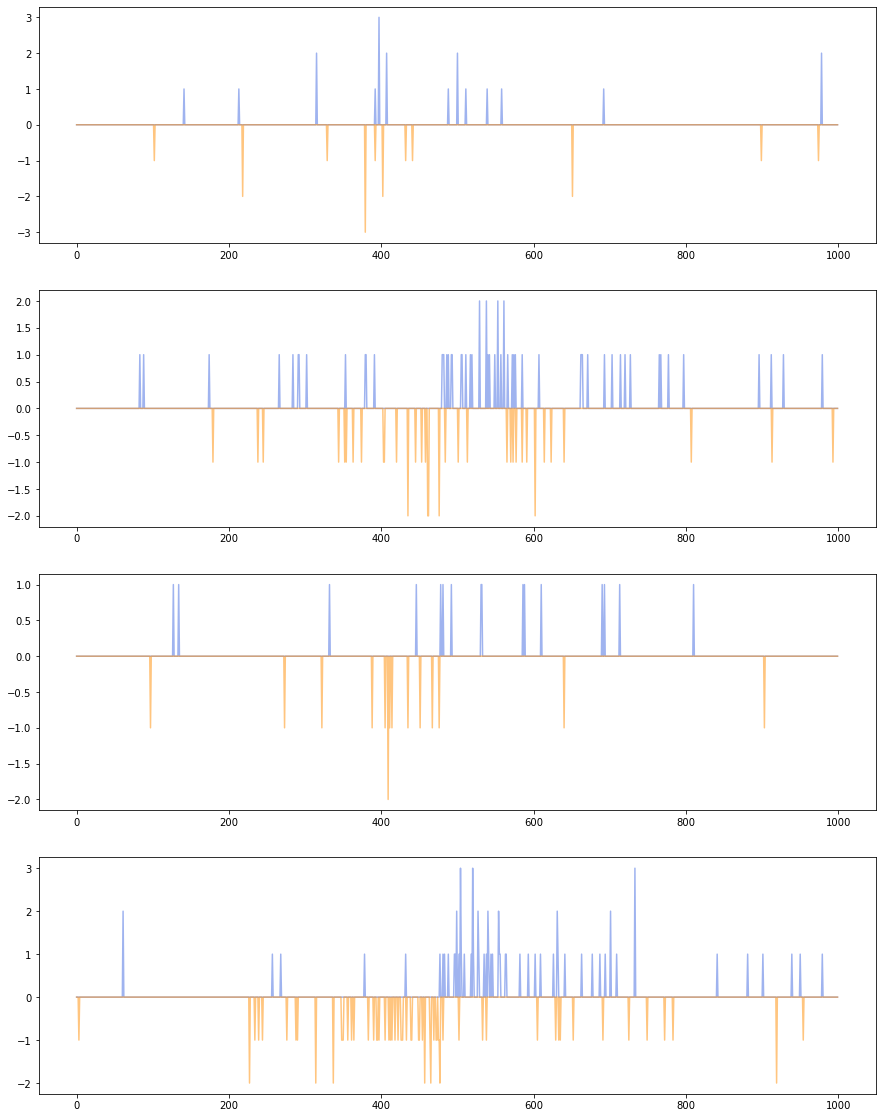

In [65]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr3", 138875547, 138876547, profile_norm_type)
print(pred_profs)
plot_profiles(pred_profs, true_profs, normalize=False)

[[[[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]

  [[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]

  [[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]

  [[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]]]
(1, 4, 1000, 2)
(1, 4, 1000, 2)
[[[nan nan]
  [nan nan]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]]


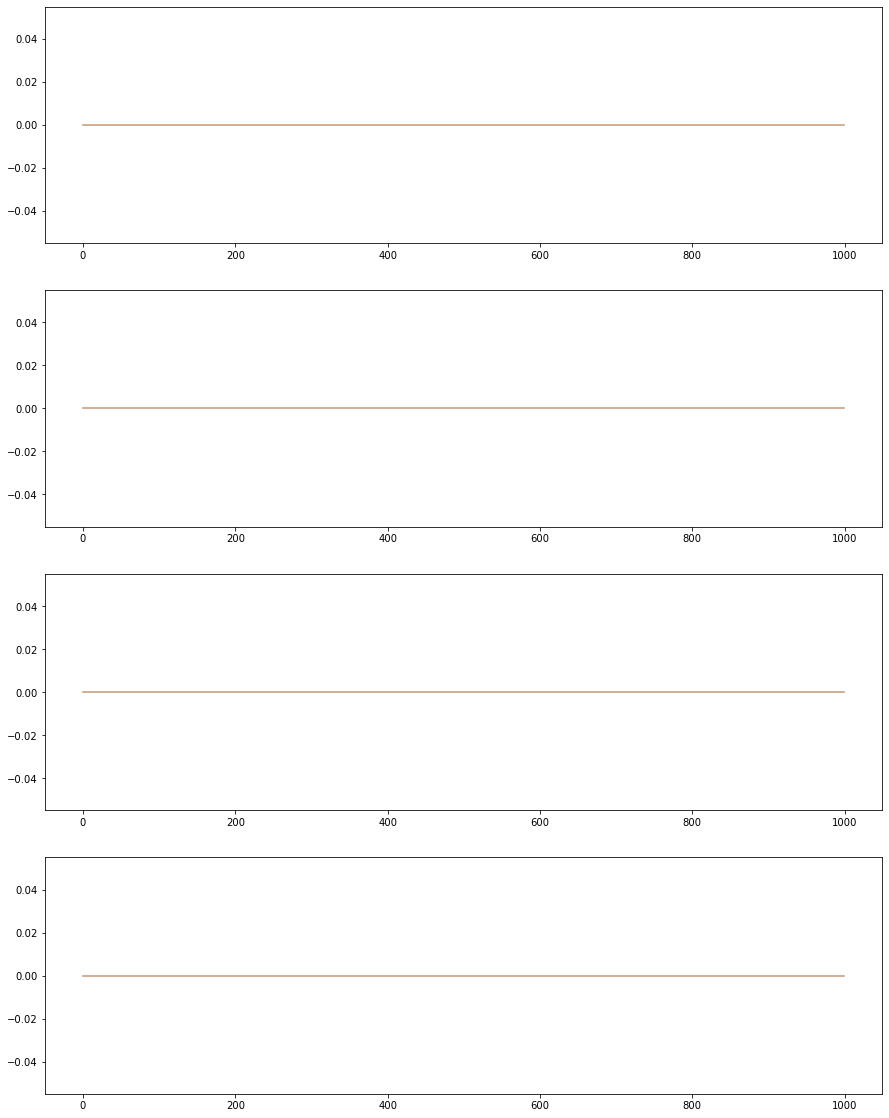

In [47]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr1", 1000, 2000, profile_norm_type)
print(pred_profs)
plot_profiles(pred_profs, true_profs, normalize=False)

[[[[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]

  [[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]

  [[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]

  [[nan nan]
   [nan nan]
   [nan nan]
   ...
   [nan nan]
   [nan nan]
   [nan nan]]]]
(1, 4, 1000, 2)
(1, 4, 1000, 2)


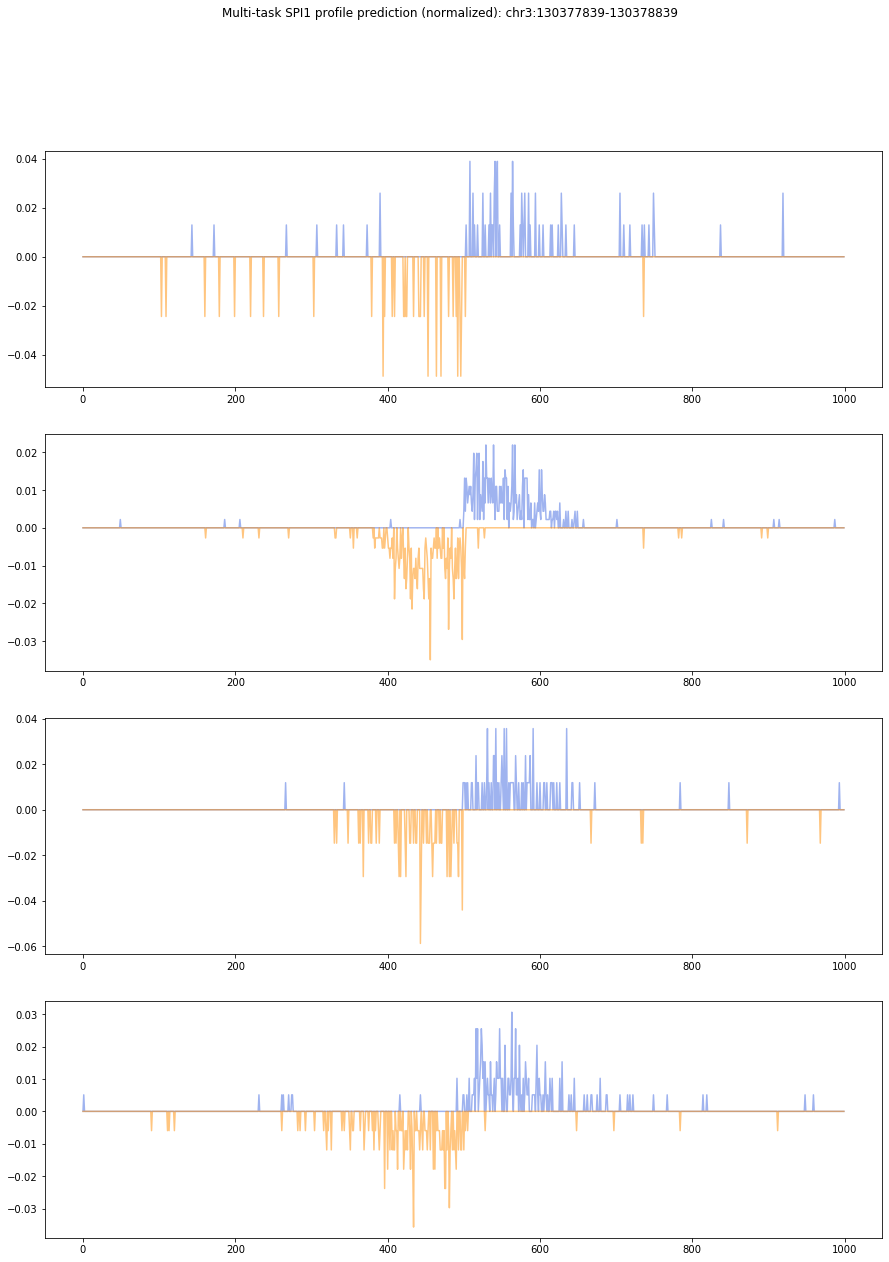

In [38]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr3", 130377839, 130378839, profile_norm_type)
plot_profiles(pred_profs, true_profs, title="Multi-task SPI1 profile prediction (normalized): chr3:130377839-130378839")

In [ ]:
pred_profs, pred_counts, true_profs, true_counts = predict_coord("chr2", 1000000, 1001000)
plot_profiles(pred_profs, true_profs)